# Data Science default prediction

For builiding a machine learning model in order to solve the above problem, we need to conduct the following processes:

*1. Data Exploration*
* Explore data, try to understand features and their types and in which form they should represent a feature
* Deal with missing values, try to impute with the best strategy
* Deal with imbalanced data, with resampling or weight adjusting

*2. Model building*
* Choose the appropriate model to implement
* Encoding features if needed
* Feature engineering
* Hyperparameter tuning

*3. Model validation*
* Usse train-test split or K-fold to validate model 
* Use confusion Matrix, precision, recall, and roc curve etc to evaluate model performance

Importing all useful libraries:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.externals import joblib
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('dataset.csv', ';')

### Data inspection

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df.tail()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
99971,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,NaN,0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,33,10.333333,NaN,Electronic equipment & Related accessories,Electronics,True,35195.0,35195.0,F1+L,0.0,0,0,0,6,2,0,0.0,0.0,0,1,1,1,1,1,1,0,0,0,60127,10.765556,NaN
99972,f8db22f4-9819-420c-abbc-9ddf1843176e,NaN,0,0.0,0.0,0.0,0.004044,1.0,1.0,NaN,1.0,1.0,44,36.000000,NaN,Body & Hair Care,Health & Beauty,True,4740.0,4740.0,F1+L,0.0,0,0,0,1,3,0,0.0,0.0,1,1,1,1,0,1,1,0,7948,0,4740,21.708333,NaN
99973,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,45671,0.0,20.0,0.0,0.705078,2.0,2.0,2.0,1.0,1.0,24,NaN,NaN,Jewelry & Watches,Jewelry & Accessories,True,1200.0,1200.0,Nick,NaN,0,0,0,0,0,0,NaN,NaN,18,0,0,0,0,0,0,0,17447,19627,3100,2.185278,NaN
99974,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,56102,0.0,0.0,0.0,0.064175,1.0,2.0,1.0,2.0,2.0,31,17.500000,NaN,Decoration & Art,Home & Garden,True,15000.0,15000.0,Nick,0.0,0,0,0,2,1,0,0.0,0.0,1,1,1,1,1,1,1,0,18339,56180,34785,9.725278,NaN
99975,ac88f18c-96a6-49bc-9e9d-a780225914af,NaN,0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,1.0,NaN,41,34.666667,37.5,Dietary supplements,Health & Beauty,True,13246.0,14817.0,F1+L,0.0,0,0,0,2,2,1,0.0,0.0,1,2,1,1,2,2,2,0,0,0,30602,11.585278,NaN


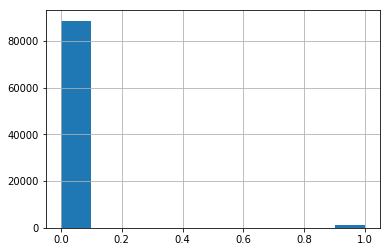

In [4]:
df.default.hist()

In [5]:
len(df[df.default==1])/len(df[df.default==0])

0.014522821576763486

We can see that the classes are highly imbalanced, with defaulted population being about only 1.5% of the non-defaulted population.

In [6]:
df.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

Filter out the rows where data.default==NaN and remove the user id and target value from the feature space:

In [7]:
#Drop rows where default value not set:
data = df.dropna(subset=['default']) 

def get_feature_space(data): #Input original dataframe 
    data.set_index('uuid', inplace=True)
    features = data.drop(['default'],1)
    return features

Group different types of features:

In [8]:
features = get_feature_space(data)
features_num = [features.dtypes.index[i] for i in range(len(features.columns)) if  features.dtypes[i]== 'float64' or features.dtypes[i]== 'int64']
features_cat = [features.dtypes.index[i] for i in range(len(features.columns)) if  features.dtypes[i]== 'bool' or features.dtypes[i]== 'object']

In [ ]:
for feature in features_cat:
    print (feature, data[feature].value_counts(dropna=False))

In [ ]:
for feature in features_num:
    print (feature, data[feature].value_counts(dropna=False))

### Deal with missing values

Features with more than 50% missing values:

In [9]:
high_na_features = features.columns[(features.isnull().sum()/len(features))>0.5]
print (high_na_features)

Index(['account_incoming_debt_vs_paid_0_24m', 'account_status',
       'account_worst_status_0_3m', 'account_worst_status_12_24m',
       'account_worst_status_3_6m', 'account_worst_status_6_12m',
       'worst_status_active_inv'],
      dtype='object')


In [ ]:
features.account_status.value_counts()

Fill the missing values with 0 for features that have more than 50% missing values:

In [10]:
def fill_missing_values(features): #Fill missing values with 0 to part of the features
    for feature in high_na_features:
        features[feature].fillna(0, inplace=True)
    return features

In [11]:
features = fill_missing_values(features)

For other features, we take the median to impute the NaN values:

In [12]:
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
imputer.fit(features[features_num]) 

def inpute_missing_values(features):
        data_features_num = pd.DataFrame(imputer.transform(features[features_num]),index=features.index, columns=features_num)
        return data_features_num

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
data_features_num = inpute_missing_values(features)

### Encoding categorical features

Here we use the technique called "one-hot" encoding to transform the categorical features, before we can do that, we need to use the "labelencoder" to transform them into numerical labels:

In [14]:
#Build label encoder first:
X_cat_label = pd.DataFrame(index=features.index) #Dataframe with encoded labels
labelencoders=[]
labels=[]

for feature in features_cat:
    le = preprocessing.LabelEncoder()
    X_cat_label[feature] = le.fit_transform(features[feature])
    labels.append(le.classes_)
    labelencoders.append(le)

labels = np.concatenate(labels)

#joblib.dump(labelencoders, "labelencoders.pkl")

# Build one-hot encoder:
enc = OneHotEncoder()
X_hotEncoded = enc.fit_transform(X_cat_label).toarray()
feature_labels = list(labels)

X_cat = pd.DataFrame(X_hotEncoded, columns=feature_labels, index=features.index)
X = pd.concat([X_cat, data_features_num], axis=1)

#joblib.dump(enc, "onehotencoder.pkl")

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
X.shape

(89976, 116)

### Prepare training data and testing data

In [16]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    print("Training length: " +str(len(y_train)))
    print("Test length: " +str(len(y_test)))
    
    return X_train, X_test, y_train, y_test

In [17]:
y = data.default

In [18]:
X_train, X_test, y_train, y_test = split_data(X, y)

Training length: 62983
Test length: 26993


### Model build

In [19]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_features=4, 
                                class_weight="balanced", 
                                n_jobs=-1, oob_score=True, verbose=True, random_state=0)

In [20]:
rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=0,
            verbose=True, warm_start=False)

## Validation of the model

For binary classification, we usually evaluate with precision and recall / F1 score and auc of the Roc curve instaead of accuracy. 

* precision = tp / (tp + fp)
* recall = tp / (tp + fn)
* f1 = 2(precision)(recall) / (precision + recall)
* Roc curve area

In [22]:
y_test_pred = rf_clf.predict(X_test)
y_pred_pb = rf_clf.predict_proba(X_test)[:, 1]

def plot_roc_curve(y_test, y_pred_pb):
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_pb)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    print('Roc_auc Score: {:.3f} \nPrecison Score:{:.3f} \nRecall Score:{:.3f} \nF1 Score (defaulter class):{:.3f}'
          .format(roc_auc_score(y_test, y_test_pred),
                 precision_score(y_test, y_test_pred),
                 recall_score(y_test, y_test_pred),
                 f1_score(y_test, y_test_pred)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


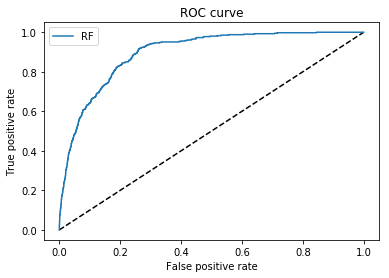

Roc_auc Score: 0.748 
Precison Score:0.116 
Recall Score:0.563 
F1 Score (defaulter class):0.192


In [23]:
plot_roc_curve(y_test, y_pred_pb)

The classification report is shown as following:

In [24]:
print (metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     26586
         1.0       0.12      0.56      0.19       407

   micro avg       0.93      0.93      0.93     26993
   macro avg       0.55      0.75      0.58     26993
weighted avg       0.98      0.93      0.95     26993



### Feature importance:

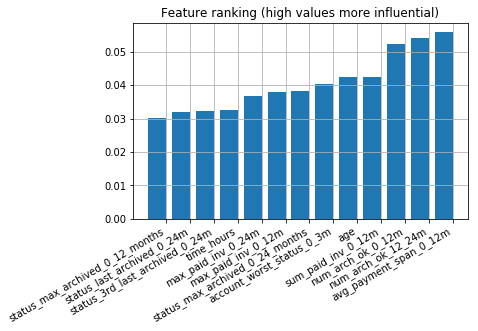

In [25]:
X_names = X_cat.columns.tolist()
X_names.extend(features_num)

imp = rf_clf.feature_importances_
sortNames = [y for (x,y) in sorted(zip(imp,X_names)) if x>0.03]
sortImp = [x for (x,y) in sorted(zip(imp,X_names)) if x>0.03]

fig = plt.figure()
ind = np.arange(len(sortImp))
width = .75
plt.bar(ind, sortImp, width=width)
plt.xticks(ind + width / 2, sortNames)
fig.autofmt_xdate()
plt.grid(True)
plt.title('Feature ranking (high values more influential)')
plt.show()

### Apply trained model to predict the datapoints where default values not set

To predict the new samples not in training or test dataset, we will need to run the whole preprocessing steps predefined in the training-validation phase on the new data to transform it into the desired format and then apply the already trained model to predict:

In [26]:
#Getting the dataframe that needs prediction:
data_pred = df[df.default.isnull()]

In [27]:
def preprocess_pipeline(data):
    
    features = get_feature_space(data)
    features = fill_missing_values(features)
    data_features_num = inpute_missing_values(features)
    
    X_le = []
    for i, le in enumerate(labelencoders):
         X_le.append(le.transform(features[features_cat[i]]))

    X_hotEncoded = enc.transform(np.asarray(X_le).T)
    X = np.concatenate([X_hotEncoded.toarray(), data_features_num], axis=1)
    X = pd.DataFrame(X, index=features.index)
    
    return X

In [28]:
data_pred_X = preprocess_pipeline(data_pred)

In [29]:
data_pred_pb = pd.DataFrame(rf_clf.predict_proba(data_pred_X)[:,1],index=data_pred_X.index,columns=['pb'])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


In [30]:
data_pred_pb.head()

,pb
uuid,
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.069098
f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.254669
e9c39869-1bc5-4375-b627-a2df70b445ea,0.176117
6beb88a3-9641-4381-beb6-c9a208664dd0,0.276409
bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.528892


In [ ]:
data_pred_pb.to_csv('output_pb.csv')